In [1]:
import pandas as pd
import os
import numpy as np
import proplot as plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

In [2]:
pth='D:\\Key_works\\20231212dh_calculate\\xnhl_test'
pth1=pth+'\\spatial_corr_analysis\\vgm_params'
pth2=pth+'\\group_err'

In [3]:
flst2=[i for i in os.listdir(pth2) if i[-4:]=='.csv']
flst1=[i for i in os.listdir(pth1) if i[-4:]=='.csv']
flst3=[i for i in os.listdir(pth2) if i[-4:]=='.tif']

In [19]:
dxt_shp=gpd.read_file('D:\\Key_works\\20231212dh_calculate\\dxt_shp_bound.gpkg')
ds_shp_bs=gpd.read_file(pth+'/shp/Basin_xn.shp')

In [20]:
df_ls=[]
pth_gla='D:\\Key_works\\20231212dh_calculate\\gla\\CGI1'
for nm in flst3:
    nmin=pth2+'\\'+nm
    nmj=pth_gla+'\\'+nm[0:5]+'_gla.shp'
    ds_hetero=xr.open_dataset(nmin,engine='rasterio')
    glai=gpd.read_file(nmj)
    ds_hetero_gi=ds_hetero.rio.clip(glai.geometry)
    herr=ds_hetero_gi['band_data'].median().values
    df_ls.append([nm[0:5],herr])
    #break
df_herr=pd.DataFrame(df_ls,columns=['group_id','herr'])

In [21]:
df_herr.head(2)

,group_id,herr
0,g0001,16.93268551402069
1,g0002,12.461997970621042


In [22]:
df_ls=[]
for nm in flst2:
    nmin=pth2+'\\'+nm
    dfi=pd.read_csv(nmin)
    dfi['group_id']=nm[0:5]
    df_ls.append(dfi)
    #break
df_hetero=pd.concat(df_ls)

In [23]:
df_hetero.head(2)

,median,nmad,median_bf,nmad_bf,group_id
0,-0.0445,16.8211,-43.4033,28.2646,g0001
0,0.4648,13.9537,-37.1162,18.9167,g0002


In [24]:
df_ls=[]
for nm in flst1:
    nmin=pth1+'\\'+nm
    dfi=pd.read_csv(nmin)
    df_ls.append([nm[0:5],dfi.iloc[0,2],dfi.iloc[1,2]])
    #break
df_corr=pd.DataFrame(df_ls,columns=['group_id','short_range','long_range'])

In [25]:
df_corr.head(2)

,group_id,short_range,long_range
0,g0001,164.262581,21722.320318
1,g0002,70.024847,1904.617937


In [26]:
dxt_error=pd.concat([dxt_shp.set_index('group'),df_corr.set_index('group_id'),df_hetero.set_index('group_id'),df_herr.set_index('group_id')],axis=1).dropna()

In [27]:
dxt_error.head(2)

,New_ID,raster_value,geometry,short_range,long_range,median,nmad,median_bf,nmad_bf,herr
g0001,0,0.0,"POLYGON ((-115514.360 3472406.642, -114314.360...",164.262581,21722.320318,-0.0445,16.8211,-43.4033,28.2646,16.93268551402069
g0002,0,0.0,"POLYGON ((-231827.755 3437049.408, -231227.755...",70.024847,1904.617937,0.4648,13.9537,-37.1162,18.9167,12.461997970621042


### 合并统计每个流域的特征

In [ ]:
## pi=0.85;pw=1;dp=0.06
## mb_err=(((ds_gla['topo_dh'].mean()/t)*(dp/pw))**2+((ds_gla.attrs['dh error']/t)*(pi/pw))**2)**0.5

In [29]:
df_effe_dxt_new=pd.read_csv(pth+'\\dh-effe-stat_more.csv',index_col=0)

In [30]:
dh_err_propa=pd.read_csv(pth+'\\dh_error_propagation.csv',index_col=0)
for i in dh_err_propa.group:
    df_effe_dxt_new.loc[df_effe_dxt_new['group_id']==i,'dh_propa_err']=dh_err_propa[dh_err_propa.group==i]['error_1sigma'].values[0]

In [31]:
df_effe_dxt_new.head(2)

,group_id,mean,median,mean_fill,median_fill,Glc_Area,Mean_Elev,Mean_Slp,Mean_Asp,MA_Elev,basin,dh_error,effe_samples,mb,mb_error,dh_propa_err
G101096E33298N,g0018,-2.247736,-4.501035,-2.532606,-4.124494,2.930313e+05,4942.3,39.4,315.8,4939.9,Yellow,3.6774,10.5176,-0.057896,0.0948,0.725481
G101108E33292N,g0018,1.705512,1.456494,1.766449,1.840311,1.968628e+06,4977.4,26.6,40.8,4998.3,Yellow,1.3081,41.6218,0.043930,0.0338,0.725481


In [33]:
dxt_error['group_id']=dxt_error.index
df_effe_dxt_new['gla_code']=df_effe_dxt_new.index

In [34]:
df_stat_final=pd.merge(df_effe_dxt_new, dxt_error, on='group_id', how='left')

In [35]:
df_stat_final.columns

Index(['group_id', 'mean', 'median_x', 'mean_fill', 'median_fill', 'Glc_Area',
       'Mean_Elev', 'Mean_Slp', 'Mean_Asp', 'MA_Elev', 'basin', 'dh_error',
       'effe_samples', 'mb', 'mb_error', 'dh_propa_err', 'gla_code', 'New_ID',
       'raster_value', 'geometry', 'short_range', 'long_range', 'median_y',
       'nmad', 'median_bf', 'nmad_bf', 'herr'],
      dtype='object')

In [27]:
df_stat_final['dh_error'].median()

4.1602

In [36]:
basin_stst=df_stat_final[['median_y','nmad','herr','dh_propa_err','effe_samples','basin','group_id']].groupby('basin')

### 统计绘图

In [22]:
dxt_error1=dxt_error.to_crs('epsg:4326')

In [23]:
dxt_error1.head(1)

,New_ID,raster_value,geometry,short_range,long_range,median,nmad,median_bf,nmad_bf,herr,group_id
g0001,0,0.0,"POLYGON ((103.74860 32.66801, 103.76160 32.668...",164.262581,21722.320318,-0.0445,16.8211,-43.4033,28.2646,16.93268551402069,g0001


In [55]:
dxt_error.columns

Index(['New_ID', 'raster_value', 'geometry', 'short_range', 'long_range',
       'median', 'nmad', 'median_bf', 'nmad_bf', 'herr', 'group_id'],
      dtype='object')

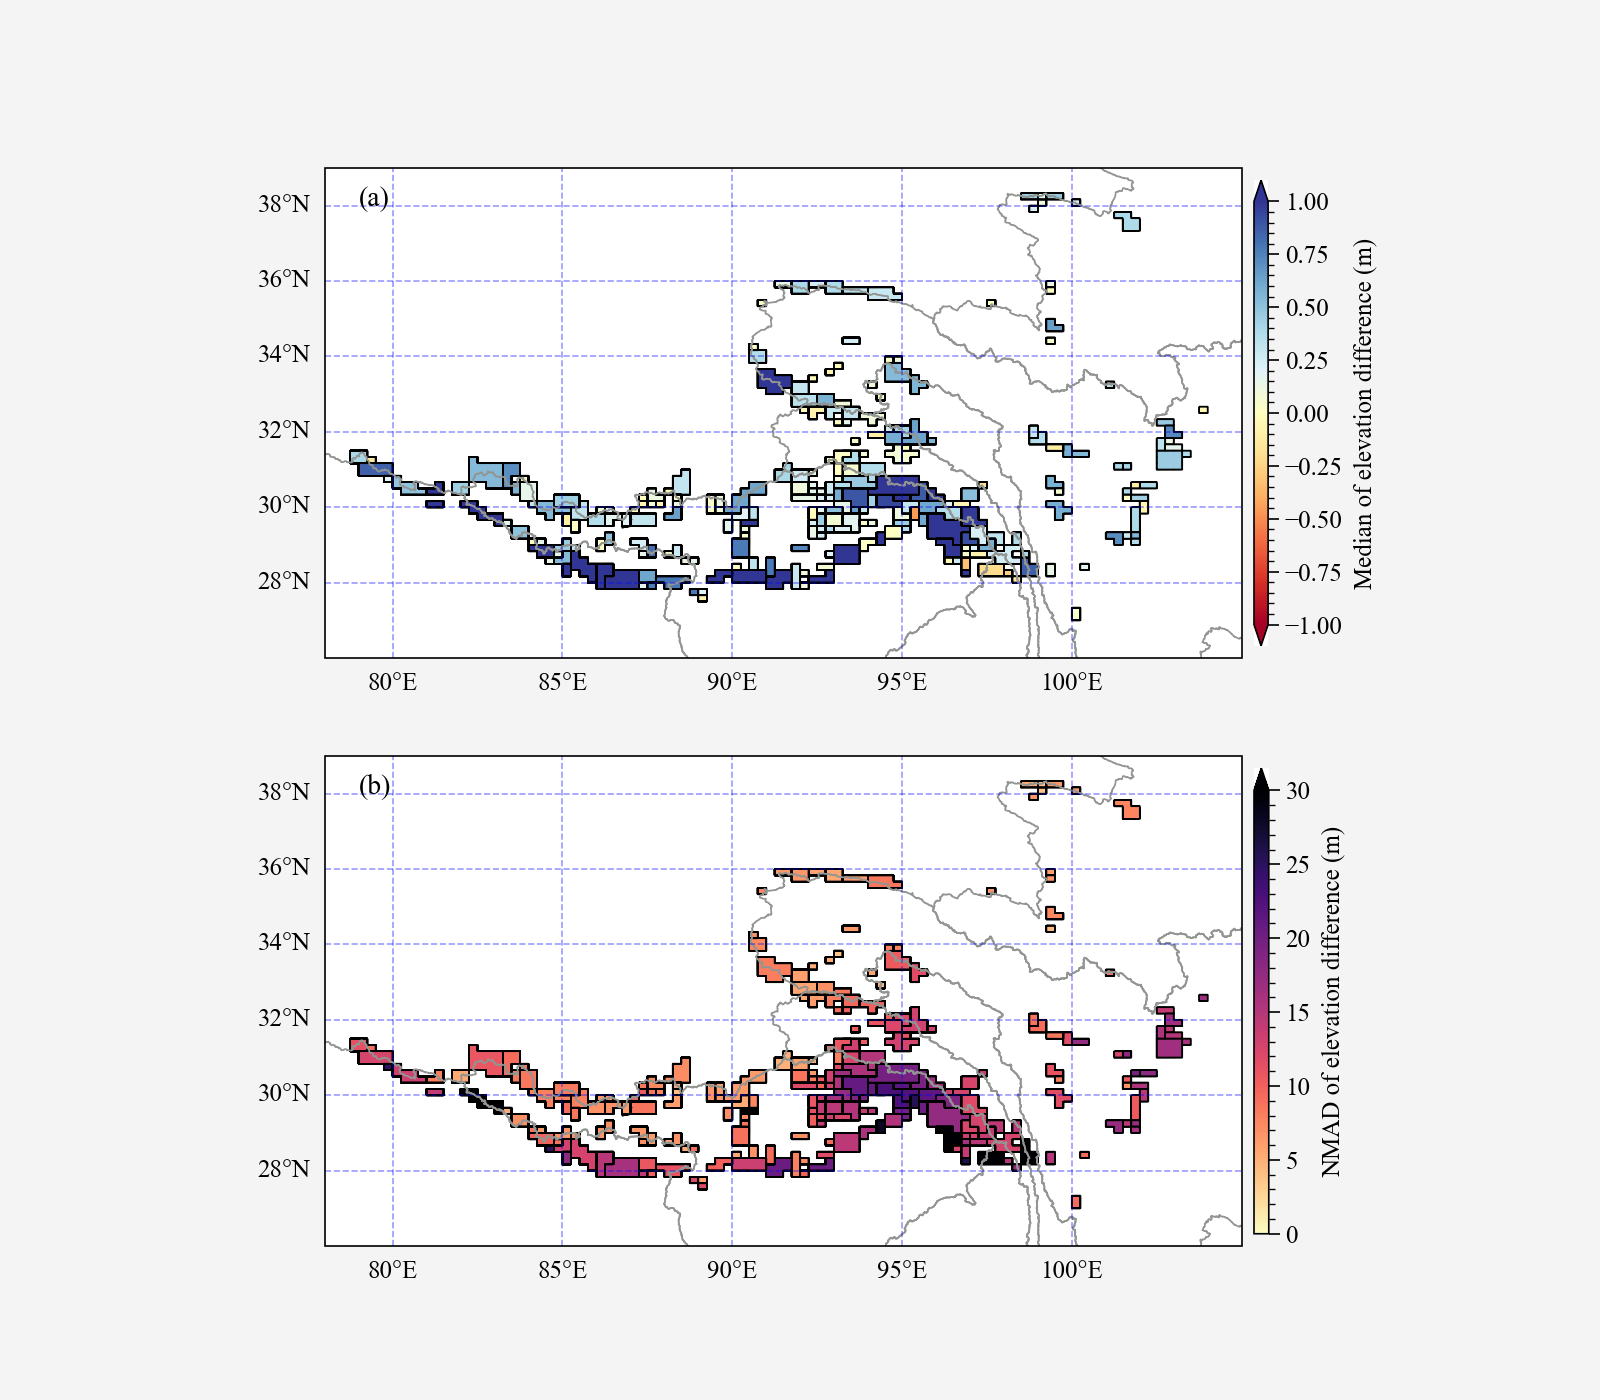

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
plt.rcParams['font.size'] = 9
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle']='--'
fig=plt.figure(figsize=[8,7])
ax1=fig.add_subplot(2, 1, 1,  projection=ccrs.PlateCarree())
ax2=fig.add_subplot(2, 1, 2,  projection=ccrs.PlateCarree())
#ax1.stock_img()
#ax1.set_extent([78, 105, 25, 40], crs=ccrs.PlateCarree())
#ax2.set_extent([78, 105, 25, 40], crs=ccrs.PlateCarree())
#tiler1 =GoogleTiles(style="satellite")
#ax1.add_image(tiler1,6,alpha=0.6)
#ax2.add_image(tiler1,6,alpha=0.6)
lg=dxt_error1.plot(
    column="median",
    cmap="rdylbu",
    edgecolor="k",
    legend=True,
    #scheme='UserDefined',
    vmin=-1,
    vmax=1,
    ax=ax1,
    legend_kwds ={'extend':'both','fraction':0.15,'shrink':0.95,'pad':0.01,'aspect':30,'label':'Median of elevation difference (m)'}
)

ds_shp_bs.plot(ax=ax1,facecolor='none',edgecolor='gray')
gl=ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='b',alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax1.set_ylim(26,39)
ax1.set_xlim(78,105)
#ax.legend(loc='ur')


lg=dxt_error1.plot(
    column="nmad",
    cmap="magma_r",
    edgecolor="k",
    legend=True,
    #scheme='Quantiles',
    vmin=0,
    vmax=30,
    ax=ax2,
    legend_kwds ={'extend':'max','fraction':0.15,'shrink':0.95,'pad':0.01,'aspect':30,'label':'NMAD of elevation difference (m)'}
)

ds_shp_bs.plot(ax=ax2,facecolor='none',edgecolor='gray')
gl=ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='b',alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax2.set_ylim(26,39)
ax2.set_xlim(78,105)
ax1.text(79.0,38,'(a)',fontsize=10)
ax2.text(79.0,38,'(b)',fontsize=10)
plt.savefig(pth+'/0Figs_paper/NMAD_median.tif',dpi=600,bbox_inches='tight')

In [42]:
dxt_error1=dxt_error.to_crs('epsg:4326')
dxt_error1['long_range']=dxt_error1['long_range']/1000

Text(79.0, 38, '(b) Long-range correlation')

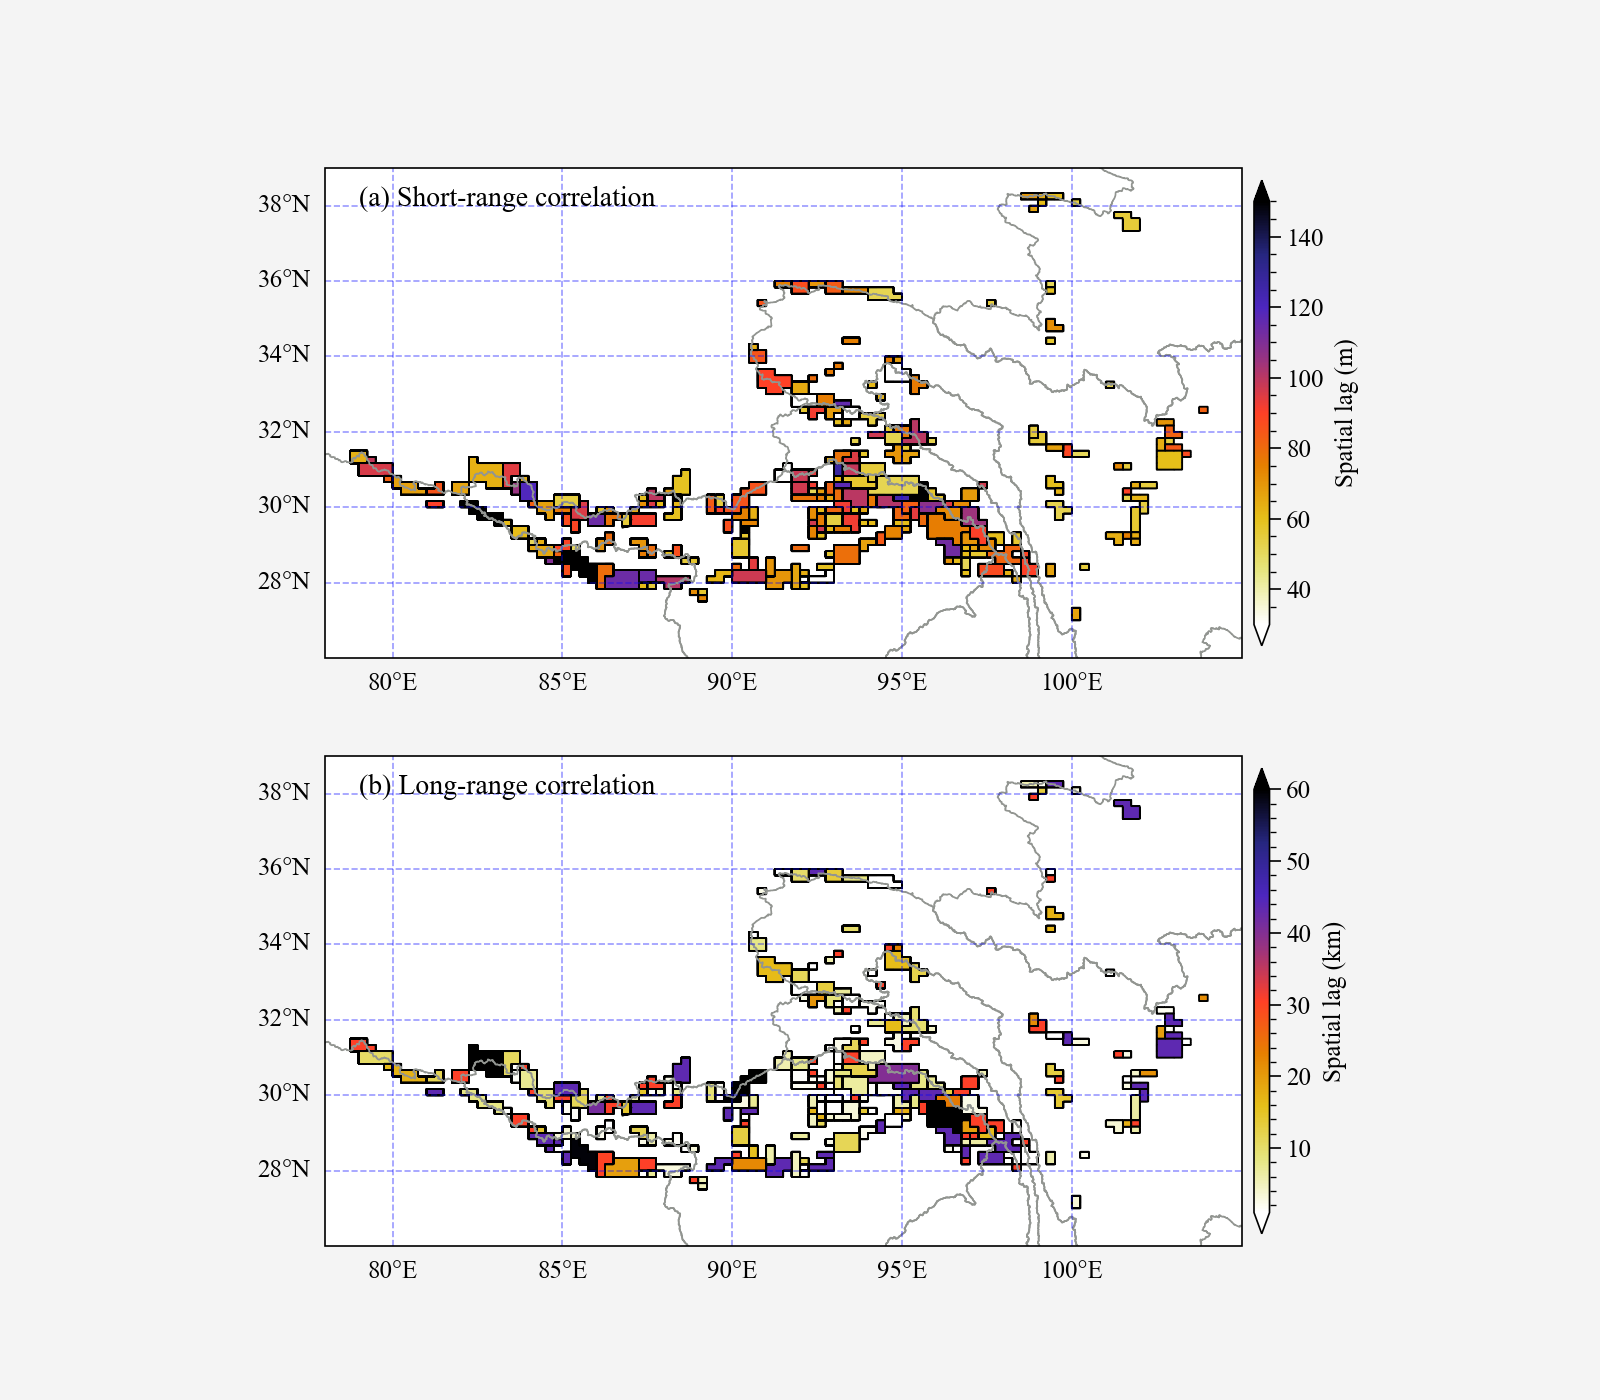

In [69]:
import cartopy.crs as ccrs
plt.rcParams['font.size'] = 9
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle']='--'
fig=plt.figure(figsize=[8,7])
ax1=fig.add_subplot(2, 1, 1,  projection=ccrs.PlateCarree())
ax2=fig.add_subplot(2, 1, 2,  projection=ccrs.PlateCarree())
#ax1.stock_img()
#ax1.set_extent([78, 105, 25, 40], crs=ccrs.PlateCarree())
#ax2.set_extent([78, 105, 25, 40], crs=ccrs.PlateCarree())
#tiler1 =GoogleTiles(style="satellite")
#ax1.add_image(tiler1,6,alpha=0.6)
#ax2.add_image(tiler1,6,alpha=0.6)
lg=dxt_error1.plot(
    column="short_range",
    cmap="cmrmap_r",
    edgecolor="k",
    legend=True,
    #scheme='UserDefined',
    vmin=30,
    vmax=150,
    ax=ax1,
    legend_kwds ={'extend':'both','fraction':0.15,'shrink':0.95,'pad':0.01,'aspect':30,'label':'Spatial lag (m)'}
)

ds_shp_bs.plot(ax=ax1,facecolor='none',edgecolor='gray')
gl=ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='b',alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax1.set_ylim(26,39)
ax1.set_xlim(78,105)
#ax.legend(loc='ur')


lg=dxt_error1.plot(
    column="long_range",
    cmap="cmrmap_r",
    edgecolor="k",
    legend=True,
    #scheme='Quantiles',
    vmin=1,
    vmax=60,
    ax=ax2,
    legend_kwds ={'extend':'both','fraction':0.15,'shrink':0.95,'pad':0.01,'aspect':30,'label':'Spatial lag (km)'}
)

ds_shp_bs.plot(ax=ax2,facecolor='none',edgecolor='gray')
gl=ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='b',alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax2.set_ylim(26,39)
ax2.set_xlim(78,105)
ax1.text(79.0,38,'(a) Short-range correlation',fontsize=10)
ax2.text(79.0,38,'(b) Long-range correlation',fontsize=10)
plt.savefig(pth+'/0Figs_paper/Spatial correlation.tif',dpi=600,bbox_inches='tight')

In [38]:
dxt_error2=dxt_error.to_crs('epsg:4326')

In [68]:
dxt_error2['dh_error']=df_stat_final[['group_id','dh_propa_err']].groupby('group_id').mean()['dh_propa_err']*2

In [40]:
import geemap
geemap.set_proxy('10809')

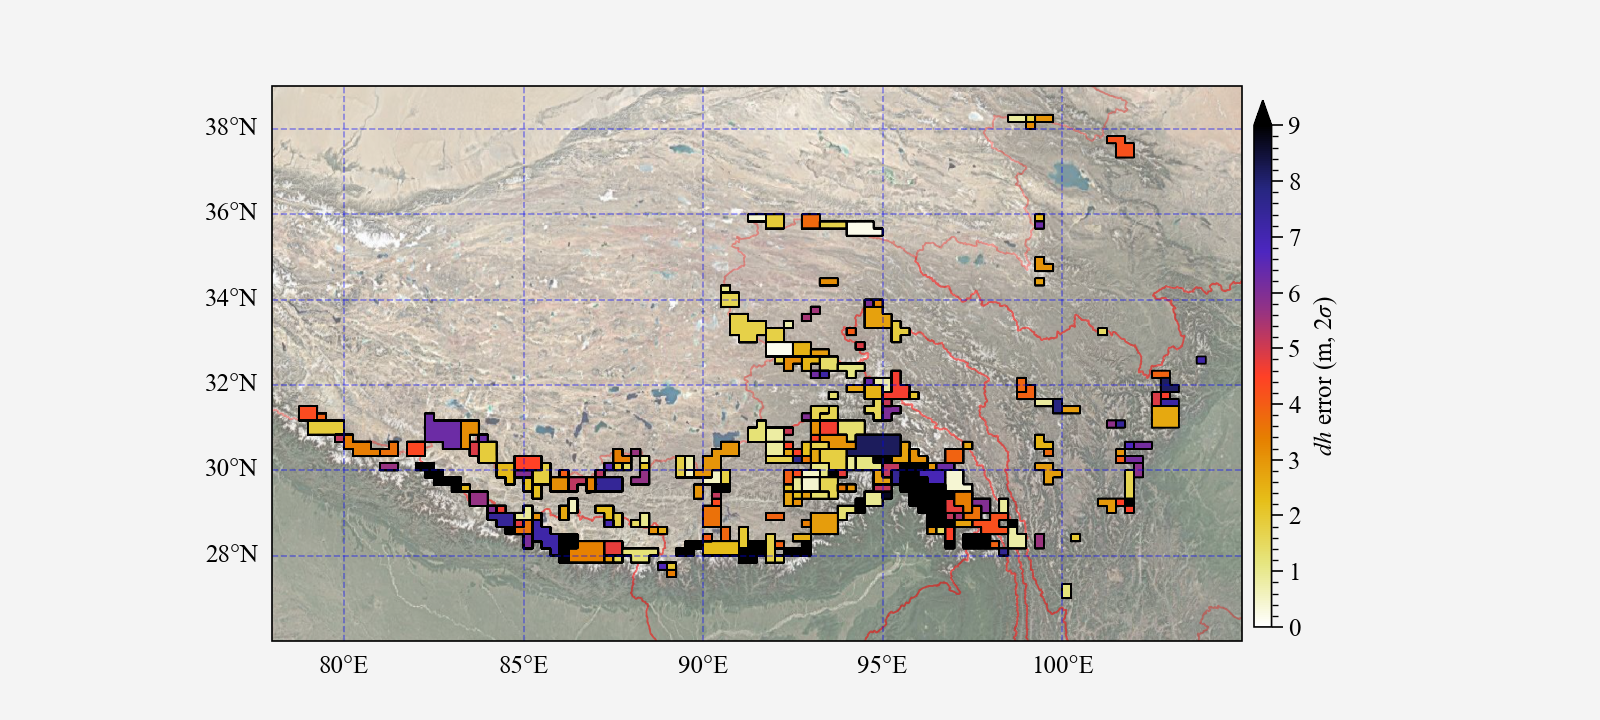

In [72]:
import cartopy.crs as ccrs
plt.rcParams['font.size'] = 9
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle']='--'
fig=plt.figure(figsize=[8,3.6])
ax1=fig.add_subplot(1, 1, 1,  projection=ccrs.PlateCarree())

#ds_shp_bs.plot(ax=ax1,edgecolor='gray',facecolor='None')
ax1.set_extent([78, 105, 25, 40], crs=ccrs.PlateCarree())
from cartopy.io.img_tiles import Stamen,GoogleTiles
tiler1 =GoogleTiles(style="satellite")

ax1.add_image(tiler1,6,alpha=0.6)
ds_shp_bs.plot(ax=ax1,edgecolor='red',facecolor='None',alpha=0.3)
lg=dxt_error2.plot(
    column="dh_error",
    cmap='CMRmap_r',
    edgecolor="k",
    legend=True,
    #scheme='UserDefined',
    vmin=0,
    vmax=9,
    ax=ax1,
    legend_kwds ={'extend':'max','fraction':0.15,'shrink':0.95,'pad':0.01,'aspect':30,'label':'$\it{dh}$ error (m, 2$\sigma$)'}
)

gl=ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='b',alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax1.set_ylim(26,39)
ax1.set_xlim(78,105)
#ax.legend(loc='ur')

#ax1.text(79.0,38,'(a) Short-range correlation',fontsize=10)
plt.savefig(pth+'/0Figs_paper/dh_error-new.tif',dpi=600,bbox_inches='tight')